# Sparkify Project Workspace


## High-level overview:

The churn problem refers to the phenomenon where customers or users of a service, such as a mobile app or a subscription-based platform, stop using the service and move on to other alternatives. Sparkify app is a music streaming service (similar to platforms like Spotify or Apple Music). In the context of the Sparkify app, churn would refer to users who stop using the app and cancel their subscriptions or disengage from the platform. In this scenario, Churn can be a critical issue for several reasons like Revenue Loss, User Acquisition Costs, Customer Lifetime Value, and Market Reputation. In a competitive market, customer retention is crucial for maintaining a competitive edge. If churn is not addressed effectively, rival apps may attract Sparkify's users to their platforms.

In this project, we classify the users of the Sparkify app into two groups: churned and non-churned users. The focus of this endeavor lies in analyzing extensive data using Pyspark and developing a web application tailored for churn classification.

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). 

In [ ]:
# !pip install plotly==5.11.0

In [1]:
# import libraries
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

# spark
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import count, when, avg, sum, isnull, col, concat, desc, explode, lit, min, max, split, udf, \
                                  collect_list

# spark ML
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.storagelevel import StorageLevel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import warnings
warnings.filterwarnings('ignore')
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# make sure visuals are embeded inside the notebook
init_notebook_mode(connected=True)
%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

# Description of Input Data

The data is in the format of JSON. Here, we work on a sample dataset that is 128 MB while the full dataset size is 12 GB. 
The Sparkify dataset contains the following columns:

```
-- artist: string (nullable = true): Artist's name
-- auth: string (nullable = true): Authentication method
-- firstName: string (nullable = true): User's first name
-- gender: string (nullable = true): User's gender
-- itemInSession: long (nullable = true): The item selected by the user in the current session.
-- lastName: string (nullable = true): User's last name
-- length: double (nullable = true): The length of current session in epoch time.
-- level: string (nullable = true): subscribtion type that is paid or free.
-- location: string (nullable = true): City and state
-- method: string (nullable = true): Type of requests from user that includes PUT, GET, SET.
-- page: string (nullable = true): The Current page selected by the user.
-- registration: long (nullable = true): The registration date.
-- sessionId: long (nullable = true): The current session id.
-- song: string (nullable = true): song title.
-- status: long (nullable = true): The request status code that can be 200, 404 and 307.
-- ts: long (nullable = true): The timestamps when user uses the app.
-- userAgent: string (nullable = true): The web browser used in current session.
-- userId: string (nullable = true): The unique Id of the user.
```

# Data Preprocessing: Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = "mini_sparkify_event_data.json"
sparkify_event = spark.read.json(path)

In [5]:
sparkify_event.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [6]:
sparkify_event.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Filtering Empty Users

Here, we plot a bar chart of Null and empty entries for each column of the data. As indicted in the figures, there is no null userIds and there are some empty UserIds, considered as non-registered users, that we remove them in the next step.

In [7]:
def plot(df, missing_type='Null'):
    """Create a bar chart of the number of missing records of either 'Null' or 'Empty-Value' value
    in each column.

    Args:
        df (DataFrame): PySpark DataFrame object
        missing_type (string): can be either 'Null' or 'Empty-Value'
    Returns:
        None
    """
    
    # Convert the PySpark DataFrame to a Pandas DataFrame for plotting
    df = df.toPandas()
    
    # Filter columns with missing records and sort in descending order
    df = df.iloc[0].loc[df.iloc[0] > 0].sort_values(ascending=False)

    # Prepare data for plotting
    x = [name.replace('_', ' ').capitalize() for name in df.index]
    y = df.values

    # Create a bar plot using Plotly
    fig = go.Figure(data=[go.Bar(x=x, y=y, text=y, marker_color='rgb(55, 83, 109)', textposition='auto',
                                 hovertext=["Missing Records in the `{}` column: {}".format(bar, count) for bar, count in zip(x, y)],
                                 hoverinfo="text")])

    # Customize the plot layout
    fig.update_layout(
        title=go.layout.Title(text="Number of {} Records per Column".format(missing_type), x=0.5),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Column Name")),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Counts"))
    )

    # Show the plot
    fig.show()

def plot_missing_values(df):
    """Create a bar chart of the number of missing records in each column and return
    a list of columns with missing values.

    Args:
        df (DataFrame): PySpark DataFrame object

    Returns:
        list: List of column names with missing values
    """
    # Calculate the count of missing records in each column
    null_counts = [count(when(col(c).isNull(), c)).alias(c) for c in df.columns]
    empty_value_counts = [count(when(col(c)=="", c)).alias(c) for c in df.columns]
    
    df_null_counts = df.select(null_counts)
    df_empty_value_counts = df.select(empty_value_counts)

    # plot
    plot(df_null_counts, 'Null')
    plot(df_empty_value_counts, 'Empty-Value')

    # Get a list of columns with missing values
    df_null = df_null_counts.toPandas()
    df_empty_value = df_empty_value_counts.toPandas()
    
    columns_with_null_values = df_null.columns[df_null.astype(bool).sum() > 0].tolist()
    columns_with_empty_values = df_empty_value.columns[df_empty_value.astype(bool).sum() > 0].tolist()
    
    return columns_with_null_values, columns_with_empty_values

columns_with_null_values, columns_with_empty_values = plot_missing_values(sparkify_event)

columns_with_null_values, columns_with_empty_values

(['artist',
  'firstName',
  'gender',
  'lastName',
  'length',
  'location',
  'registration',
  'song',
  'userAgent'],
 ['userId'])

In [8]:
empty_user_ids_size = sparkify_event.filter(sparkify_event["userId"] == "").count()
sparkify_event = sparkify_event.filter(sparkify_event["userId"] != "")
num_valid_entries = sparkify_event.count()
num_distict_users = sparkify_event.select("userId").distinct().count()
data_size = sparkify_event.count()
print(f"There are {data_size} entries in the data set, with {empty_user_ids_size} empty 'userId' entries. The non-empty 'userId' entries is {num_valid_entries} with {num_distict_users} users.")

There are 278154 entries in the data set, with 8346 empty 'userId' entries. The non-empty 'userId' entries is 278154 with 225 users.


# Exploratory Data Analysis

Here we do exploratory analysis and polt several figures to get an insight to the data.

In [9]:
sparkify_event.groupby("auth").agg(F.count("auth")).show()
sparkify_event.groupby("userAgent").agg(F.count("userAgent")).show()
sparkify_event.select("userAgent").distinct().count()
sparkify_event.groupby("page").agg(F.count("page")).show()
sparkify_event.select('status').distinct().show()

+---------+-----------+
|     auth|count(auth)|
+---------+-----------+
|Cancelled|         52|
|Logged In|     278102|
+---------+-----------+

+--------------------+----------------+
|           userAgent|count(userAgent)|
+--------------------+----------------+
|"Mozilla/5.0 (Mac...|             240|
|"Mozilla/5.0 (Win...|            5238|
|Mozilla/5.0 (X11;...|              62|
|"Mozilla/5.0 (Mac...|           18448|
|"Mozilla/5.0 (Mac...|            1262|
|Mozilla/5.0 (Maci...|            2442|
|Mozilla/5.0 (Wind...|            3214|
|Mozilla/5.0 (Wind...|            5989|
|Mozilla/5.0 (comp...|            8624|
|"Mozilla/5.0 (Win...|            7624|
|Mozilla/5.0 (Maci...|           10300|
|"Mozilla/5.0 (Win...|            2168|
|"Mozilla/5.0 (iPh...|            1976|
|"Mozilla/5.0 (Win...|           15395|
|Mozilla/5.0 (Wind...|           16700|
|Mozilla/5.0 (comp...|            1245|
|Mozilla/5.0 (comp...|             815|
|"Mozilla/5.0 (Mac...|             235|
|"Mozilla/5.0 (

### Distinct Values

The following figures show the number of distinct categories in the columns of the data with at least 60 distinct category. 

In [10]:
def get_number_of_distinct_records(df, columns, max_distinct_records=60):
    """Print number of distinct categories in each column, and return
       a list of columns with at most max_distinct_records records.

    Args:
        df (DataFrame): PySpark DataFrame object
        max_distinct_records (int): an upper bound on the number of distict records
    Returns:
        cols (list): a list of column names with at most max_distinct_records distinct records
    """
    
    cols = []
    for column in columns:
        num_distinct_record = sparkify_event.select(column).distinct().count()
        print(f"There are {num_distinct_record} distinct categories in column '{column}'.")
        
        if num_distinct_record <= max_distinct_records:
            cols.append(column) 
            
    return cols

cols_to_explore = get_number_of_distinct_records(sparkify_event, sparkify_event.columns)
print(cols_to_explore)

There are 17656 distinct categories in column 'artist'.
There are 2 distinct categories in column 'auth'.
There are 189 distinct categories in column 'firstName'.
There are 2 distinct categories in column 'gender'.
There are 1311 distinct categories in column 'itemInSession'.
There are 173 distinct categories in column 'lastName'.
There are 14866 distinct categories in column 'length'.
There are 2 distinct categories in column 'level'.
There are 114 distinct categories in column 'location'.
There are 2 distinct categories in column 'method'.
There are 19 distinct categories in column 'page'.
There are 225 distinct categories in column 'registration'.
There are 2312 distinct categories in column 'sessionId'.
There are 58481 distinct categories in column 'song'.
There are 3 distinct categories in column 'status'.
There are 269770 distinct categories in column 'ts'.
There are 56 distinct categories in column 'userAgent'.
There are 225 distinct categories in column 'userId'.
['auth', 'gend

In [11]:
import pandas as pd
import plotly.graph_objects as go
from pyspark.sql.functions import col, count

def plot_category_counts(df, column_name):
    """Create a bar chart of the counts of different categories in a specific column.

    Args:
        df (DataFrame): PySpark DataFrame object
        column_name (str): Name of the column to plot its category counts.

    Returns:
        None
    """
    # Calculate the counts of each category in the specified column
    category_counts = df.groupBy(column_name).agg(count("*").alias("count")).orderBy(col("count").desc())

    # Convert the PySpark DataFrame to a Pandas DataFrame for plotting
    category_counts_df = category_counts.toPandas()

    # Prepare data for plotting
    x = category_counts_df[column_name].values
    y = category_counts_df["count"].values

    # Create a bar plot using Plotly
    fig = go.Figure(data=[go.Bar(x=x, y=y, text=y, marker_color='rgb(55, 83, 109)', textposition='auto',
                                 hovertext=["Category: {}<br>Count: {}".format(cat, count) for cat, count in zip(x, y)],
                                 hoverinfo="text")])

    # Customize the plot layout
    fig.update_layout(
        title=go.layout.Title(text="Counts of Different Categories in Column '{}'".format(column_name), x=0.5),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text=column_name)),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Counts"))
    )

    # Show the plot
    fig.show()


In [12]:
for col_name in cols_to_explore:
    plot_category_counts(sparkify_event, col_name)

### Number of Churned Users and Churned Rate

In [13]:
num_users_churned = sparkify_event.where((col("page") == "Cancellation Confirmation")).select("userId").distinct().count()

total_users = sparkify_event.select("userId").distinct().count()
print(f"Number of cancellations is {num_users_churned} out of {total_users} users. Therefore, the churn rate is {round(100*num_users_churned/total_users, 2)}%.")


Number of cancellations is 52 out of 225 users. Therefore, the churn rate is 23.11%.


### Number of New Users Per Month

In [ ]:
def new_users_plot(df):
    """Create a monthly bar chart for the number of new users in each month.
    
        Args:
            df (DataFrame): Pyspark Dataframe object
        Returns:
            None
        
    """
        
    registrations = df.select("registration", "userId").toPandas().dropna()
    registrations["date"] = pd.to_datetime([datetime.datetime.fromtimestamp(date/1000) for date in registrations.registration])
    count_series = registrations.resample('M', on='date').count()["registration"]
    
    fig = go.Figure(data=go.Bar(x=count_series.index, y=count_series.values))

    fig.update_layout(
        xaxis_title='Months',
        yaxis_title='New Users',
        title='Number of New Users per Month'
    )

    fig.show()

    
new_users_plot(sparkify_event)

### Is 'page' == 'Cancel' is equivalent of 'page' == 'Cancellation Confirmation'?
The following analysis shows that userIds with 'page' == 'Cancel' and 'page' == 'Cancellation Confirmation' are the same.


In [14]:
sparkify_event.select(["userId", "page"]).where(sparkify_event.page == "Cancellation Confirmation").collect()


# Filter the DataFrame to get rows where 'page' is either 'Cancel' or 'Cancellation Confirmation'
cancel_df = sparkify_event.filter((col('page') == 'Cancel') | (col('page') == 'Cancellation Confirmation'))

# Group the DataFrame by 'userId' and count the occurrences
user_counts = cancel_df.groupBy('userId').count()

# Filter to get userIds where both 'Cancel' and 'Cancellation Confirmation' pages are present
user_both_pages = user_counts.filter(col('count') == 2).select('userId')

# Show the userIds where both pages are present
user_both_pages.show()

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
|    28|
|100022|
|100025|
|300007|
|100006|
|    18|
|    70|
|100005|
|    17|
|100007|
+------+
only showing top 20 rows



# Strategy for solving the problem
Based on the comprehensive Exploratory Data Analysis (EDA) conducted above, we define a churned user as someone whose page is set to canceled. Our analysis then focuses on fidning and analyzing relevant features that will be incorporated into our ML model. Following a well-established ML practice, we scale the selected features.

For the ML model, we start by considering a simple Logistic Regression (LR) model as our baseline to establish an initial working ML model on the provided dataset. The simplicity of the LR model allows us to easily observe and study the significance of different features by examining their corresponding LR coefficients. After performing hyperparameter tuning using grid search for the LR model, we proceed with the Random Forest (RF) Model.

The choice of RF is motivated by the fact that most of the features are potentially discrete, and RF tends to perform well in such scenarios. Additionally, using RF models helps prevent overfitting to the training data without resorting to more complex and computationally expensive tree-based methods like the xgboost method. Using the RF model, we expect to see a better performance compared to the LR model in a reasonable amount of time.

As highlighted in the EDA section above, we noticed a significant class imbalance in the provided data, with the churn rate representing only 23% of the entire dataset. In the presence of imbalanced data, it is crucial to consider precision and recall for evaluating the performance of the underlying ML models. Therefore, instead of relying on accuracy score, we will assess and compare the performance of our models based on the area under the curve (AUC) of the ROC curve and the AUC of the precision-recall curve. These metrics provide a more robust evaluation in imbalanced settings. 

# Feature Engineering

After exploring the sample DataFrame, I create a new DataFrame called features_df which contains re-engineered features for the ML modeling. The new DataFrame df_features contains the following features:

- userId: unique Id for each user.
- Churned: whether the user is still a customer or not. If the user is still a customer then Churned is False. If not, then True.
- SongsPlayed: the number of Songs played by a user.
- ThumbsUp: the number of times the user voted a song up.
- ThumbsUp: the number of times the user voted a song down.
- Days: the number of days since the user started using Sparkify.
- upPerSong: the ratio of songs voted up by a user.
- downPerSong: the ratio of songs voted down by a user.
- songsPerHour: the ratio between the total number of songs and the played hours since the user subscribed to Sparkify.


## 1) Error Info Feature

In [15]:
error_df = sparkify_event.groupBy("userId").pivot("status", [200, 404, 307]).count().fillna(0)
error_df = error_df.withColumnRenamed("200", "status_200") \
       .withColumnRenamed("404", "status_404") \
       .withColumnRenamed("307", "status_307")
error_df.take(5)

[Row(userId='200002', status_200=437, status_404=0, status_307=37),
 Row(userId='100010', status_200=350, status_404=0, status_307=31),
 Row(userId='125', status_200=10, status_404=0, status_307=1),
 Row(userId='124', status_200=4468, status_404=6, status_307=351),
 Row(userId='7', status_200=187, status_404=1, status_307=13)]

## 2 & 3) Number of Thumbs Up and Down

These features indicate the proportion of songs that a user has voted up or down.

In [16]:
# Thumbs up
thumbs_up_df = sparkify_event.where(sparkify_event.page=='Thumbs Up').groupby("userId").agg(count(col('page')).alias('ThumbsUp')).orderBy('userId')
json_file_path='thumbs_up.json'
thumbs_up_df.toPandas().to_json(json_file_path, orient='records', lines=True)   

# Thumbs down
thumbs_down_df = sparkify_event.where(sparkify_event.page=='Thumbs Down').groupby("userId").agg(count(col('page')).alias('ThumbsDown')).orderBy('userId')
json_file_path='thumbs_down.json'
thumbs_down_df.toPandas().to_json(json_file_path, orient='records', lines=True) 

# Combining up and down data
thumbs_up_down_df = thumbs_up_df.join(thumbs_down_df,'userId')
json_file_path='thumbs_up_down.json'
thumbs_up_down_df.toPandas().to_json(json_file_path, orient='records', lines=True) 

## 4) Number of Songs Played

This feature represents the total number of songs played by a user during their subscription period.

In [17]:
num_songs_df = sparkify_event.where(col('song')!='null').groupby("userId").agg(count(col('song')).alias('SongsPlayed')).orderBy('userId')
json_file_path='num_songs.json'
num_songs_df.toPandas().to_json(json_file_path, orient='records', lines=True) 

## 5) Duration of Sparkify Subscription for Users

Here we calculate the duration of app usage for each user. In the next few cells, we present a boxplot illustrating how significant this feture is.

In [18]:
num_days_df = sparkify_event.groupby('userId').agg(((max(col('ts')) - min(col('ts')))/86400000).alias("Days"))
json_file_path='num_days.json'
num_days_df.toPandas().to_json(json_file_path, orient='records', lines=True) 

# 6 & 7) Gender and Level Information

Here, we generate gender and level flags to include them as extra features in the classification task. In the next few cells, using bar charts, we show their potential significance in churn classification.

In [19]:
def binary_data(df, old_column_name, value, new_column_name):
    """Return a DataFrame where users are categorized by their churn group.
    
        Args:
            df (DataFrame): Pyspark Dataframe object
        Returns:
            DataFrame (df): Pyspark Dataframe with churn classfication for each user
    """
    new_df = df.groupby('userId').agg(collect_list(old_column_name).alias('tmp'))
    condition = udf(lambda x: value in str(x))
    new_df = new_df.withColumn(new_column_name, condition(new_df['tmp'])) # create a column with True or False for Churn users
    new_df = new_df.drop('tmp') # drop auths - redundant after creating the Churned column
    
    return new_df

churn_df = binary_data(sparkify_event, 'auth', 'Cancelled', "Churned")
gender_df = binary_data(sparkify_event, 'gender', 'F', "GenderInfo")
level_df = binary_data(sparkify_event, 'Level', 'paid', "Pay")

# Selecting columns
selected_columns=['artist','auth','gender','length','level','location','page','song','ts','userId']
cleaned_sparkify_event_df = sparkify_event.select(selected_columns)

cleaned_sparkify_event_df = churn_df.join(cleaned_sparkify_event_df,'userId')
cleaned_sparkify_event_df = gender_df.join(cleaned_sparkify_event_df,'userId')
cleaned_sparkify_event_df = level_df.join(cleaned_sparkify_event_df,'userId')
cleaned_sparkify_event_df = error_df.join(cleaned_sparkify_event_df,'userId')
cleaned_sparkify_event_df.show(5) 


non_churned_df = cleaned_sparkify_event_df.filter(cleaned_sparkify_event_df['Churned'] == 'false')
churned_df = cleaned_sparkify_event_df.filter(cleaned_sparkify_event_df['Churned'] == 'true')



+------+----------+----------+----------+-----+----------+-------+--------------------+---------+------+---------+-----+--------------------+---------+--------------------+-------------+
|userId|status_200|status_404|status_307|  Pay|GenderInfo|Churned|              artist|     auth|gender|   length|level|            location|     page|                song|           ts|
+------+----------+----------+----------+-----+----------+-------+--------------------+---------+------+---------+-----+--------------------+---------+--------------------+-------------+
|100010|       350|         0|        31|false|      true|  false|Sleeping With Sirens|Logged In|     F|202.97098| free|Bridgeport-Stamfo...| NextSong|Captain Tyin Knot...|1539003534000|
|100010|       350|         0|        31|false|      true|  false|Francesca Battist...|Logged In|     F|196.54485| free|Bridgeport-Stamfo...| NextSong|Beautiful_ Beauti...|1539003736000|
|100010|       350|         0|        31|false|      true|  false

## Justification for the Significance of Subscription Duration

To check the significance of subscription duration feature, we generate a box plot that illustrates the difference in app usage days between 'churned' and 'non-churned' users. The plot clearly demonstrates that 'churned' users have utilized the app for a shorter duration compared to 'non-churned' users. This suggests that this particular feature holds potential significance for the churn classification task.

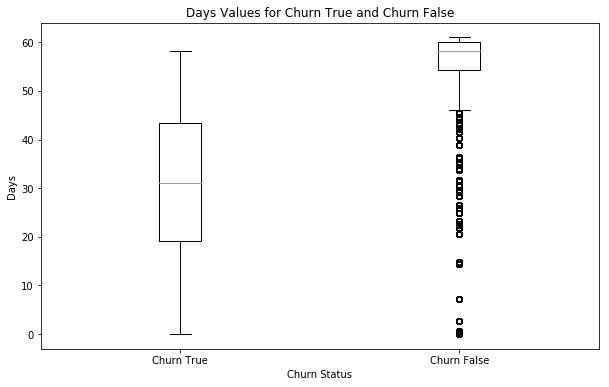

In [20]:
# Filter 'Days' values for userIds where 'Churn' is true
churn_true_df = cleaned_sparkify_event_df.filter(col('Churned') == 'true')
churn_true_ids = churn_true_df.select('userId')
days_churn_true = num_days_df.join(churn_true_ids, on='userId', how='inner').select('Days').toPandas()

# Filter 'Days' values for userIds where 'Churn' is false
churn_false_df = cleaned_sparkify_event_df.filter(col('Churned') == 'false')
churn_false_ids = churn_false_df.select('userId')
days_churn_false = num_days_df.join(churn_false_ids, on='userId', how='inner').select('Days').toPandas()

# Plot the 'Days' values for each group using a box plot
plt.figure(figsize=(10, 6))
plt.boxplot([days_churn_true['Days'], days_churn_false['Days']], labels=['Churn True', 'Churn False'])
plt.xlabel('Churn Status')
plt.ylabel('Days')
plt.title('Days Values for Churn True and Churn False')
plt.show()


# Plotly version
# plotly_df = pd.concat([days_churn_true.assign(Churn='Churn True'), days_churn_false.assign(Churn='Churn False')])
# fig = px.box(plotly_df, x='Churn', y='Days', title='Days Values for Churn True and Churn False', points="all")
# fig.show()

In [ ]:
# days_churn_true.to_csv('days_churn_true.csv') 
# days_churn_false.to_csv('days_churn_false.csv')

## Justification for the Significance of Geneder and Level Information

To check the significance of gender and level info features, we generate bar charts that illustrate their potential significance in telling 'churned' and 'non-churned' users. 

#### Gender information

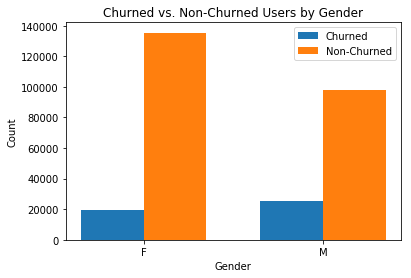

In [21]:
# Pandas version

churned_gender_counts = churned_df.groupBy('gender').count().toPandas()
non_churned_gender_counts = non_churned_df.groupBy('gender').count().toPandas()

width = 0.35
x = np.arange(len(churned_gender_counts))

fig, ax = plt.subplots()
ax.bar(x - width/2, churned_gender_counts['count'], width, label='Churned')
ax.bar(x + width/2, non_churned_gender_counts['count'], width, label='Non-Churned')
ax.set_xticks(x)
ax.set_xticklabels(churned_gender_counts['gender'])
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Churned vs. Non-Churned Users by Gender')
ax.legend()
plt.show()


In [ ]:
# churned_gender_counts.to_csv('churned_gender_counts.csv') 
# non_churned_gender_counts.to_csv(non_churned_gender_counts.csv)

In [ ]:
# #Plotly version

# # Separate churned and non-churned users
# churned_df = cleaned_sparkify_event_df.filter(cleaned_sparkify_event_df['Churned'] == 'true')
# non_churned_df = cleaned_sparkify_event_df.filter(cleaned_sparkify_event_df['Churned'] == 'false')

# # Calculate the counts of Male and Female users for each group
# churned_gender_counts = churned_df.groupBy('gender').count().collect()
# non_churned_gender_counts = non_churned_df.groupBy('gender').count().collect()

# # Extract the genders and counts for plotting
# genders = [item['gender'] for item in churned_gender_counts]
# churned_counts = [item['count'] for item in churned_gender_counts]
# non_churned_counts = [item['count'] for item in non_churned_gender_counts]

# # Create the bar chart
# fig = go.Figure(data=[
#     go.Bar(name='Churned', x=genders, y=churned_counts),
#     go.Bar(name='Non-Churned', x=genders, y=non_churned_counts)
# ])

# # Update the layout of the chart
# fig.update_layout(
#     title='Churned vs. Non-Churned Users by Gender',
#     xaxis_title='Gender',
#     yaxis_title='Count',
#     barmode='group'
# )

# # Show the chart
# fig.show()

#### Level Information

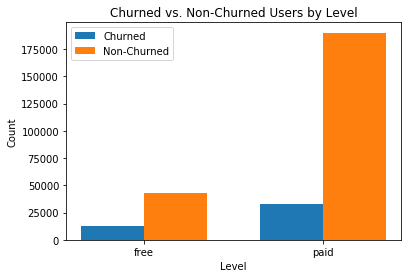

In [22]:
# pandas version

# Calculate the counts of 'paid' and 'free' users for each group
churned_level_counts = churned_df.groupBy('Level').count().toPandas()
non_churned_level_counts = non_churned_df.groupBy('Level').count().toPandas()

# Create the bar chart using Matplotlib
width = 0.35
x = np.arange(len(churned_level_counts))

fig, ax = plt.subplots()
ax.bar(x - width/2, churned_level_counts['count'], width, label='Churned')
ax.bar(x + width/2, non_churned_level_counts['count'], width, label='Non-Churned')
ax.set_xticks(x)
ax.set_xticklabels(churned_level_counts['Level'])
ax.set_xlabel('Level')
ax.set_ylabel('Count')
ax.set_title('Churned vs. Non-Churned Users by Level')
ax.legend()
plt.show()


In [23]:
# csv_file_path='churned_level_counts.csv'
# churned_level_counts.to_csv(csv_file_path) 

# csv_file_path='non_churned_level_counts.csv'
# non_churned_level_counts.to_csv(csv_file_path)

In [24]:
# # Plotly version
# # Calculate the counts of 'paid' and 'free' users for each group
# churned_level_counts = churned_df.groupBy('Level').count().collect()
# non_churned_level_counts = non_churned_df.groupBy('Level').count().collect()

# # Extract the levels and counts for plotting
# levels = [item['Level'] for item in churned_level_counts]
# churned_counts = [item['count'] for item in churned_level_counts]
# non_churned_counts = [item['count'] for item in non_churned_level_counts]

# # Create the bar chart
# fig = go.Figure(data=[
#     go.Bar(name='Churned', x=levels, y=churned_counts),
#     go.Bar(name='Non-Churned', x=levels, y=non_churned_counts)
# ])

# # Update the layout of the chart
# fig.update_layout(
#     title='Churned vs. Non-Churned Users by Level',
#     xaxis_title='Level',
#     yaxis_title='Count',
#     barmode='group'
# )

# # Show the chart
# fig.show()

# Creating Feature DataFrame by Joining the Created Features

In [25]:
# join gender data
features_df = churn_df.join(gender_df,'userId')

# join level data
features_df = features_df.join(level_df,'userId')

# join error data
features_df = features_df.join(error_df,'userId')

# join the df_churn data with songsPlayed
features_df = features_df.join(num_songs_df,'userId') 

# join the df_features data with allThumbs which contains data on Thumps up/down
features_df = features_df.join(thumbs_up_down_df,'userId')

# join the df_features data with days
features_df = features_df.join(num_days_df, "userId")

# check the df_features
# features_df.show()

In [26]:

# create user defined functions to create the last three columns
# upPerSong is number of thumbs up divided by the number of songs
upPerSong = udf(lambda numUp, songs: numUp/songs, FloatType())

# downPerSong is number of thumbs down divided by the number of songs
downPerSong = udf(lambda numDown, songs: numDown/songs, FloatType())

# songsPerHour is number of songs divided by the number of hours where the user stayed active in the log
songsPerHour = udf(lambda numSongs, numDays: numSongs/(numDays*24), FloatType())

# Gender
gender = udf(lambda genderInfo: 0 if genderInfo == 'false' else 1, IntegerType())

# Level
level = udf(lambda levelInfo: 0 if levelInfo == 'false' else 1, IntegerType())

# create the df_features data frame
# features_df = features_df.drop("Gender","LevelInfo","ErrorInfo","UpPerSong", "DownPerSong", "SongsPerHour")
features_df = features_df.withColumn("Gender", gender(features_df.GenderInfo))
features_df = features_df.withColumn("LevelInfo", level(features_df.Pay))
features_df = features_df.withColumn("UpPerSong", upPerSong(features_df.ThumbsUp, features_df.SongsPlayed))
features_df = features_df.withColumn("DownPerSong", downPerSong(features_df.ThumbsDown, features_df.SongsPlayed))
features_df = features_df.withColumn("SongsPerHour", songsPerHour(features_df.SongsPlayed, features_df.Days))
features_df = features_df.drop("GenderInfo","Pay")


In [27]:
features_df.toPandas().to_csv('features_df.csv')

## Sampling the Dataset

Here, to reduce the computational time we sample the dataset while we keep the distribution of churned and non-churned data points. In this procedure, we sample 50% of churned and non-churned data points.

In [28]:
# Define the fractions for sampling
fractions = features_df.select("Churned").distinct().withColumn("fraction", lit(0.5)).rdd.collectAsMap()

# Sample the DataFrame using sampleBy
sampled_df = features_df.sampleBy("Churned", fractions, seed=42)


## Selecting, Scaling and Transforming the Feature Vector Dataset

In [29]:
# spark ML
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.storagelevel import StorageLevel
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import warnings
warnings.filterwarnings('ignore')

numerical_cols = ["Gender", "LevelInfo", "SongsPlayed", "UpPerSong", "DownPerSong", "Days", "SongsPerHour", "status_200", "status_404", "status_307"]
assembler = VectorAssembler(inputCols = numerical_cols, outputCol = "FeatureVector")
sampled_df = assembler.transform(sampled_df)
scaler = StandardScaler(inputCol="FeatureVector", outputCol="ScaledFeatures", withStd=True)
scalerModel = scaler.fit(sampled_df)
sampled_df = scalerModel.transform(sampled_df)
# features_df.show()

In [30]:
# sampled_df.take(5) # check the created df_features DataFrame

In [31]:
sampled_df.dtypes

[('userId', 'string'),
 ('Churned', 'string'),
 ('status_200', 'bigint'),
 ('status_404', 'bigint'),
 ('status_307', 'bigint'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsUp', 'bigint'),
 ('ThumbsDown', 'bigint'),
 ('Days', 'double'),
 ('Gender', 'int'),
 ('LevelInfo', 'int'),
 ('UpPerSong', 'float'),
 ('DownPerSong', 'float'),
 ('SongsPerHour', 'float'),
 ('FeatureVector', 'vector'),
 ('ScaledFeatures', 'vector')]

## Creating Labels for Churn Groups

In [32]:
convertToInt = udf(lambda x: 1 if x=="true" else 0, IntegerType())
sampled_df = sampled_df.withColumn('label', convertToInt(sampled_df.Churned))
# features_df.show()

In [33]:
csv_file_path='sampled_df.csv'
sampled_df.toPandas().to_csv(csv_file_path, index=False)

# ML Modeling

In the begining we split the data into train (80%) and test (20%) sets. Then, we use Logicistic Regression (LR) as a baseline for the ML modeling. After LR model, we use Random Forest (RF) to classify the Churned users.

We evaluate the LR and RF models using ROC and Precision-Recall curves and their area under curve (AUC) values. We plot the curves along with presenting their AUC values. 

Furthermore, considering the computational time, we choose a very small grid parameters for the hyperparameter tuning.


## Splitting the Data to Train and Test Datasets

In [34]:
# Split the DataFrame into train and test sets (80%, 20%)
weights = [0.8, 0.2]
seed = 42

train_df, test_df = sampled_df.randomSplit(weights, seed)

In [35]:
test_df_pandas = test_df.toPandas()
test_df_pandas.to_csv('test_df.csv', index=False)

train_df_pandas = train_df.toPandas()
train_df_pandas.to_csv('train_df.csv', index=False)

## Logistic Regression Model

In [37]:
# Create the Logistic Regression Classifier
lrModel = LogisticRegression(featuresCol='FeatureVector', labelCol='label')

# Define the hyperparameter grid for random search
#     .addGrid(lrModel.elasticNetParam, [0.0, 1.0]) \ # Just commented out to reduce the computational time
paramGrid = ParamGridBuilder() \
    .addGrid(lrModel.regParam, [0.1, 1.0]) \
    .addGrid(lrModel.maxIter, [5, 10]) \
    .build()

# Set up the evaluator for AUC of PR curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',
                                          labelCol='label',
                                          metricName='areaUnderPR')

# Perform random search with cross-validation
cross_validator = CrossValidator(estimator=lrModel,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           numFolds=3)

# Fit the random search model on the training data
lrModel = cross_validator.fit(train_df)

# Get the best model from the random search
best_lr_model = lrModel.bestModel

# Make predictions on the test data using the best model
lr_test_predictions = best_lr_model.transform(test_df)
lr_test_predictions_pd = lr_test_predictions.select('label', 'probability').toPandas()
lr_test_predictions_pd.to_csv('lr_test_predictions_pd.csv', index=False)

### Variable Coefficients in the Trained LR Model

In [41]:
coefs = [round(x,2) for x in best_lr_model.coefficients]

print("Intercept: " + str(best_lr_model.intercept))
coefs_df = pd.DataFrame({'Feature_Name': numerical_cols, 'Feature_Coefficient': coefs})
coefs_df.to_csv('coefs_df.csv', index=False)
display(coefs_df)

fig = go.Figure()

# Positive bars with green color
fig.add_trace(go.Bar(
    x=coefs_df['Feature_Name'][coefs_df['Feature_Coefficient'] >= 0],
    y=coefs_df['Feature_Coefficient'][coefs_df['Feature_Coefficient'] >= 0],
    marker_color='green',
    name='Positive Coefficients'
))

# Negative bars with red color
fig.add_trace(go.Bar(
    x=coefs_df['Feature_Name'][coefs_df['Feature_Coefficient'] < 0],
    y=coefs_df['Feature_Coefficient'][coefs_df['Feature_Coefficient'] < 0],
    marker_color='red',
    name='Negative Coefficients'
))

fig.update_layout(
    title='Feature Coefficients (Diverging)',
    xaxis_title='Feature Name',
    yaxis_title='Feature Coefficient'
)

fig.show()

Intercept: -1.0299595903287697


,Feature_Name,Feature_Coefficient
0,Gender,-0.03
1,LevelInfo,0.72
2,SongsPlayed,-0.00
3,UpPerSong,0.89
4,DownPerSong,64.34
5,Days,-0.04
6,SongsPerHour,-0.03
7,status_200,-0.00
8,status_404,-0.03
9,status_307,-0.00


## NOTE: Justification for the Evaluation Metrics
As we observed in the EDA section, the provided data is imbalanced, with a churn rate of only 23% of the entire dataset. In such situations, precision and recall become the most reliable evaluation metrics to consider. Consequently, we will assess the performance of our ML models using the AUC (Area Under the Curve) of the ROC curve and the Precision-Recall curves for both the train and test datasets. These metrics provide valuable insights into the model's ability to handle imbalanced data and help us make more informed decisions about model performance.

### Evaluation of the LR Model on Training Data

In [42]:
lr_training_summary = best_lr_model.summary

#### ROC Curve

In [44]:
lr_training_roc = lr_training_summary.roc.toPandas()
lr_training_roc.to_csv('lr_training_roc.csv', index=False)

fig = go.Figure()
fig.add_trace(go.Scatter(x=lr_training_roc['FPR'], y=lr_training_roc['TPR'], 
                         mode='lines', line=dict(color='darkorange', width=2),
                         name='ROC curve (area = %0.2f)' % lr_training_summary.areaUnderROC))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', width=2, dash='dash'),
                         name='Baseline'))

fig.update_layout(
    title='LR-ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
)

fig.show()


#### PR Curve

In [45]:
lr_training_pr = lr_training_summary.pr.toPandas()
lr_training_pr.to_csv('lr_training_pr.csv', index=False)

fig = go.Figure()
fig.add_trace(go.Scatter(x=lr_training_pr['recall'], y=lr_training_pr['precision'], 
                         mode='lines', line=dict(color='darkorange', width=2),
                         name='Precision-Recall Curve'))

# Plot the baseline line
fig.add_trace(go.Scatter(x=[0, 1], y=[1, 0], mode='lines', line=dict(color='navy', width=2, dash='dash'),
                         name='Baseline'))

fig.update_layout(
    title='LR-Precision-Recall Curve',
    xaxis_title='Recall',
    yaxis_title='Precision',
)

fig.show()


### Evaluation of the LR Model on Test Data by Plotting ROC and PR Curves

#### ROC Curve

In [46]:
# Function to calculate ROC curve and AUC
def calculate_roc_curve(predictions_pd):
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(predictions_pd['label'], predictions_pd['probability'].apply(lambda x: x[1]))
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

fpr, tpr, roc_auc = calculate_roc_curve(lr_test_predictions_pd)


lr_roc_metrics = pd.DataFrame({'TPR':tpr, 'FPR':fpr})
lr_roc_metrics.to_csv('lr_test_roc_metrics.csv', index=False)

# Create the ROC curve
fig_roc = go.Figure(data=go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(color='darkorange', width=2), name='ROC Curve'))
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', width=2, dash='dash'), name='Baseline'))
fig_roc.update_layout(
    title=f'LR-ROC Curve (AUC = {roc_auc:.2f})',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
)

fig_roc.show()

#### PR Curve


In [47]:
# Function to calculate precision-recall curve and AUC
def calculate_precision_recall_curve(predictions_pd):
    from sklearn.metrics import precision_recall_curve, auc

    precision, recall, thresholds = precision_recall_curve(predictions_pd['label'], predictions_pd['probability'].apply(lambda x: x[1]))
    pr_auc = auc(recall, precision)

    return precision, recall, pr_auc

precision, recall, pr_auc = calculate_precision_recall_curve(lr_test_predictions_pd)

lr_pr_metrics = pd.DataFrame({'Precision': precision, 'Recall': recall})
lr_pr_metrics.to_csv('lr_test_pr_metrics.csv', index=False)

# Create the Precision-Recall curve
fig_pr = go.Figure(data=go.Scatter(x=recall, y=precision, mode='lines', line=dict(color='darkorange', width=2), name='Precision-Recall Curve'))
fig_pr.add_trace(go.Scatter(x=[0, 1], y=[1, 0], mode='lines', line=dict(color='navy', width=2, dash='dash'), name='Baseline'))

fig_pr.update_layout(
    title=f'LR-Precision-Recall Curve (AUC = {pr_auc:.2f})',
    xaxis_title='Recall',
    yaxis_title='Precision',
)

fig_pr.show()

## Random Forest Model

In [48]:
# Create the RandomForestClassifier
rf = RandomForestClassifier(featuresCol='FeatureVector', labelCol='label')

# Define the hyperparameter grid for random search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.featureSubsetStrategy, ['auto']) \
    .build()

# Set up the evaluator for AUC of PR curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',
                                          labelCol='label',
                                          metricName='areaUnderPR')

# Perform random search with cross-validation
cross_validator = CrossValidator(estimator=rf,
                                   estimatorParamMaps=paramGrid,
                                   evaluator=evaluator,
                                   numFolds=3)

# Fit the random search model on the training data
rfModel = cross_validator.fit(train_df)

# Get the best model from the random search
best_rf_model = rfModel.bestModel

# Make predictions on the test data using the best model
rf_test_predictions = best_rf_model.transform(test_df)
rf_test_predictions_pd = rf_test_predictions.select('label', 'probability').toPandas()
rf_test_predictions_pd.to_csv('rf_test_predictions_pd.csv', index=False)

In [56]:
# Function to calculate ROC curve and AUC
def calculate_roc_curve(predictions_pd):
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(predictions_pd['label'], predictions_pd['probability'].apply(lambda x: x[1]))
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

In [60]:
# Function to calculate precision-recall curve and AUC
def calculate_precision_recall_curve(predictions_pd):
    from sklearn.metrics import precision_recall_curve, auc

    precision, recall, thresholds = precision_recall_curve(predictions_pd['label'], predictions_pd['probability'].apply(lambda x: x[1]))
    pr_auc = auc(recall, precision)

    return precision, recall, pr_auc

### Evaluation of the RF Model on Train Data by Plotting ROC and PR Curves

In [57]:
# Make predictions on the train data using the best model
rf_train_predictions = best_rf_model.transform(train_df)
rf_train_predictions_pd = rf_train_predictions.select('label', 'probability').toPandas()
rf_train_predictions_pd.to_csv('rf_train_predictions_pd.csv', index=False)

#### ROC Curve

In [61]:
fpr, tpr, rf_roc_auc = calculate_roc_curve(rf_train_predictions_pd)

rf_roc_metrics = pd.DataFrame({'TPR':tpr, 'FPR':fpr})
rf_roc_metrics.to_csv('rf_train_roc_metrics.csv', index=False)

# Create the ROC curve
fig_roc = go.Figure(data=go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(color='darkorange', width=2), name='ROC Curve'))
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', width=2, dash='dash'), name='Baseline'))
fig_roc.update_layout(
    title=f'RF-ROC Curve (AUC = {rf_roc_auc:.2f}) - Train Data',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
)

fig_roc.show()

#### PR Curve

In [63]:
precision, recall, rf_pr_auc = calculate_precision_recall_curve(rf_train_predictions_pd)

rf_pr_metrics = pd.DataFrame({'Precision': precision, 'Recall': recall})
rf_pr_metrics.to_csv('rf_train_pr_metrics.csv', index=False)

# Create the Precision-Recall curve
fig_pr = go.Figure(data=go.Scatter(x=recall, y=precision, mode='lines', line=dict(color='darkorange', width=2), name='Precision-Recall Curve'))
fig_pr.add_trace(go.Scatter(x=[0, 1], y=[1, 0], mode='lines', line=dict(color='navy', width=2, dash='dash'), name='Baseline'))

fig_pr.update_layout(
    title=f'RF-Precision-Recall Curve (AUC = {rf_pr_auc:.2f}) - Train Data',
    xaxis_title='Recall',
    yaxis_title='Precision',
)

fig_pr.show()

### Evaluation of the RF Model on Test Data by Plotting ROC and PR Curves

#### ROC Curve

In [64]:
fpr, tpr, rf_roc_auc = calculate_roc_curve(rf_test_predictions_pd)

rf_roc_metrics = pd.DataFrame({'TPR':tpr, 'FPR':fpr})
rf_roc_metrics.to_csv('rf_test_roc_metrics.csv', index=False)

# Create the ROC curve
fig_roc = go.Figure(data=go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(color='darkorange', width=2), name='ROC Curve'))
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', width=2, dash='dash'), name='Baseline'))
fig_roc.update_layout(
    title=f'RF-ROC Curve (AUC = {rf_roc_auc:.2f}) - Test Data',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
)

fig_roc.show()

#### PR Curve

In [65]:
precision, recall, rf_pr_auc = calculate_precision_recall_curve(rf_test_predictions_pd)

rf_pr_metrics = pd.DataFrame({'Precision': precision, 'Recall': recall})
rf_pr_metrics.to_csv('rf_test_pr_metrics.csv', index=False)

# Create the Precision-Recall curve
fig_pr = go.Figure(data=go.Scatter(x=recall, y=precision, mode='lines', line=dict(color='darkorange', width=2), name='Precision-Recall Curve'))
fig_pr.add_trace(go.Scatter(x=[0, 1], y=[1, 0], mode='lines', line=dict(color='navy', width=2, dash='dash'), name='Baseline'))

fig_pr.update_layout(
    title=f'RF-Precision-Recall Curve (AUC = {rf_pr_auc:.2f}) - Test Data',
    xaxis_title='Recall',
    yaxis_title='Precision',
)

fig_pr.show()

## Logistic Regression vs. Random Forest

The following table compares the performance of the Logistic Regression (RL) and the Random Forest Model (RF) on the test data in terms of AUC of PR curve and ROC curve. This table indicates that both models achive perfect AUC's on the test data.

In [54]:
results = pd.DataFrame()
results['Method'] = ['RL', 'RF']
results['PR-AUC'] = [pr_auc, rf_pr_auc]
results['ROC-AUC'] = [roc_auc, rf_roc_auc]
display(results)

,Method,PR-AUC,ROC-AUC
0,RL,1.0,1.0
1,RF,1.0,1.0


## Conclusion

### Summary of the End-to-End Solution:
After loading the data and conducting Exploratory Data Analysis, we observed that the provided dataset is relatively clean, with very few null entries. While there were no null userIds, a small portion of empty userIds was present, which we interpreted as guest users, deemed irrelevant for our churn analysis. Consequently, we opted to remove them from the dataset.

The subsequent step involved feature engineering, where we experimented with and analyzed different features to assess their correlation with users being churned or non-churned. After arriving at an appropriate set of features, we first trained and evaluated a simple baseline model, i.e., the LR model. Subsequently, we trained and evaluated a Random Forest (RF) model, comparing its performance with the LR model.

While the RF model exhibited superior performance on the training data, both models performed equally well on the test data. In examining the LR coefficients corresponding to different features, we identified the number of thumbs down per song as the most crucial feature in predicting churn.

Due to the substantial computational time required by Spark when running locally, we had to train and cross-validate our model on a sample of the provided dataset. Although we anticipate the RF model to outperform the LR model when applied to the entire larger dataset, to ensure more reliable results, we intend to cross-validate and evaluate our models on a cluster of machines provided by cloud providers. 

By leveraging the cluster of machines provided by cloud providers, we can efficiently handle the entire dataset. This allows us to perform a more extensive hyperparameter search over a larger set of hyperparameters, which can lead to fine-tuning our models and optimizing their performance. Additionally, with the increased computational capabilities, we can train and test more advanced ML models, such as xgboost, which may yield improved predictive power and generalization. Ultimately, this enhanced computational capacity will empower us to make better decisions regarding model selection and deployment, thereby maximizing the effectiveness of our churn analysis and prediction process.

### Overview of the evolution of our solutions throughout the project:

Before finalizing our proposed solution, we thoroughly explored two important aspects:

Imbalanced Data: Initially, we attempted to address the imbalanced data situation by partitioning the userIds and introducing artificial labels in addition to the churned vs. non-churned labels. However, despite trying various approaches, it became apparent that introducing artificial labels was not a straightforward task. As a result, we made a well-founded decision to utilize the AUC of the ROC and the Precision-Recall curves as evaluation metrics. These metrics are better suited for handling imbalanced data, providing a more accurate assessment of our model's performance.

Feature Engineering: During the process of feature analysis, we carefully considered features like the userAgent column and location but found limited significance in their predictability of churned users. However, upon exploring the boxplot for the number of days a user subscribed to the system, along with bar charts for gender and level information, we observed a correlation between these additional features and churned users. Consequently, we made a data-driven choice to include these relevant features in our final model.

By thoroughly examining these aspects and making informed decisions based on the analysis, we have arrived at a well-considered and robust solution to tackle the challenges posed by the imbalanced data and enhance the predictive capabilities of our model.

### Why some techniques worked better than others:
We expect that the Random Forest model will consistently outperform simpler methods like Logistic Regression. The reason behind this expectation lies in the nature of the provided data. As we cannot ascertain whether the data is linearly separable, relying on a linear model like Logistic Regression may not yield optimal performance.

The next straightforward approach, besides the linear models, would be to consider decision trees. However, decision trees are susceptible to overfitting, especially when the model becomes too complex and fits the training data too closely. This overfitting issue is effectively addressed by the Random Forest approach, which is an ensemble learning method based on the idea of bootstrapping. By aggregating multiple decision trees, Random Forest mitigates overfitting tendencies, leading to improved generalization and better performance on unseen data. Consequently, we have good reasons to anticipate that the Random Forest model will indeed surpass the performance of simpler methods like Logistic Regression on the provided dataset.

We also expect that Gradient Boosting Tree approaches like xgboost outperform the Random Forest approach. Both xgboost and Random Forest are ensemble learning methods designed to address overfitting and improve generalization. However, xgboost takes it a step further by incorporating the boosting idea, which enables it to iteratively improve its performance by focusing on correcting errors made by previous iterations.

### Discussion and Challenges:

Owing to the substantial size of the data and the slow processing speed of Spark, the notebook, especially the sections related to model training, tends to take a significant amount of time to execute. This becomes quite challenging, particularly when the kernel becomes disconnected. To overcome this issue, I adopted a strategy of saving intermediate results frequently. Additionally, during the model training process, I opted to randomly subset half of the provided dataset while ensuring the distribution of the labeled data was carefully considered. Additionally, I performed hyperparameter tuning on only a limited set of hyperparameters to expedite the process and manage computational resources more efficiently.